## Q leaning with value function aproximation

In [1]:
import numpy as np
import gym
from gym import Env
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn.functional as F
from torch.optim import Optimizer, SGD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.kernel_approximation import RBFSampler

# Logging in a good format
! pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

from typing import Callable, Dict
import itertools

# Set torch random seed and numpy random seed
torch.manual_seed(42)
np.random.seed(42)


C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### The sate of the environment 
- x: the car position
- v: the linear speed of the car
- theta: the angle of the pole
- omega: the angular velocilty of the pole

In [2]:
env = gym.make('CartPole-v1')
env.reset()

# Min and max values for each dimension
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
observation_samples = np.array([env.observation_space.sample() for x in range(1000)]) 
scaler = StandardScaler()
scaler.fit(observation_samples)
# too many states generates overflow in dist paramas computation

mean_states = observation_samples.mean(axis=0)
std_states = observation_samples.std(axis=0)

def normalize_state(state: Tensor) -> Tensor:
    return (state - torch.from_numpy(mean_states)) / torch.from_numpy(std_states)
    

C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [4]:
class Cos(nn.Module):
    def __init__(self) -> None:
        super(Cos, self).__init__()
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return torch.cos(input)

class Aproximator(nn.Module):
    def __init__(self, cfg: Dict) -> None:
        super(Aproximator, self).__init__()
        self.input_size = cfg["input_size"]
        self.output_size = cfg["output_size"]
        self.activation = cfg["activation"]
        
        self.linear = nn.Linear(in_features=self.input_size, out_features=self.output_size, bias=True)
        
        # Init paramters 
        dist = torch.normal(0, 1, size=(1, 8)).view(2, 4)
        params = torch.sqrt(torch.Tensor([2 * 5, 2 * 2, 2 * 1, 2 * 0.5]))
        self.linear.weight = nn.Parameter(dist * params, requires_grad=True)
        unif  = torch.distributions.Uniform(0, 2 * torch.pi)
        self.linear.bias = nn.Parameter(torch.Tensor([unif.sample() for _ in range(2)]), requires_grad=True)
        
        if self.activation == "sigmoid":
            # Linear transformations
            self.net = nn.Sequential(
                self.linear,
                # nn.Linear(in_features=self.input_size, out_features=self.output_size * 4, bias=True),
                # nn.ReLU(),
                # nn.Linear(in_features=self.output_size * 4, out_features=self.output_size * 2, bias=True),
                # nn.ReLU(),
                # nn.Linear(in_features=self.output_size * 2, out_features=self.output_size, bias=True),
                nn.Sigmoid()
            )
        elif self.activation == "cos":
            self.net = nn.Sequential(
                self.linear,
                Cos()
            )
        else: 
            self.net = nn.Sequential(
                self.linear,
                nn.Tanh()
            )
            
    def encoder(self, x: np.ndarray) -> np.ndarray:
        return scaler.transform(x)
    
    
    def forward(self, x: np.ndarray) -> Tensor:
        x = self.encoder(x.reshape(1, -1))
        x = torch.from_numpy(x)
        return self.net(x)
    

## Epsilon greedy policy function

In [5]:
def epsilon_greedy_policy(aproximator: Aproximator, eps: float, number_of_actions: int) -> Callable:
    
    def policy_fn(observation: np.ndarray) -> np.ndarray:
        A = np.ones(number_of_actions, dtype=float) * eps / number_of_actions
        q_values = aproximator(observation)
        best_action = np.argmax(q_values.detach().numpy())
        A[best_action] += (1.0 - eps)
        return A
    
    return policy_fn

## Q learning 

In [6]:
def q_learning( env: Env, 
                aproximator: Aproximator,
                optimizer: Optimizer,
                num_epochs: int, 
                gamma: float = 0.9, # default discount factor 
                eps: float = 0.1,
                eps_decay_factor: float = 0.9 # for eps decay
              ):
    
    # Create a loss function for the aproximator
    loss_fn = torch.nn.MSELoss()
    losses = []
    rewards = []
    
    for epoch in range(num_epochs):
        
        policy = epsilon_greedy_policy(
            aproximator=aproximator, 
            eps=eps * eps_decay_factor**epoch, 
            number_of_actions=env.action_space.n
        )
        
        state = env.reset()
        reward_sum = 0

        for t in itertools.count():
            
            action_probabilities = policy(state)
            action = np.random.choice(np.arange(len(action_probabilities)), p=action_probabilities)
            
            next_state, reward, end, _ = env.step(action)
            
            q_values_next = aproximator(next_state)
            td_target = reward + gamma * torch.max(q_values_next)
            
            loss = loss_fn(td_target, torch.max(q_values_next))
            loss.backward()
            optimizer.step()
    
            losses.append(loss.detach().numpy().item())
            reward_sum += reward
            
            if epoch % 10000 == 0:
                print("\rStep {} @ Episode {}/{} ({})".format(t, epoch + 1, num_epochs, reward))
                
            if end:
                break     
            state = next_state
        
        rewards.append(reward_sum)
        
    return losses, rewards

In [13]:
aproximator = Aproximator(cfg={
    "input_size": 4,
    "output_size": 2,
    "activation": "sigmoid"
})

In [14]:
optimizer = SGD(params=aproximator.parameters(), lr=1e-4)

In [15]:
losses, rewards = q_learning(aproximator=aproximator, optimizer=optimizer, env=env, num_epochs=1000)

Step 0 @ Episode 1/1000 (1.0)
Step 1 @ Episode 1/1000 (1.0)
Step 2 @ Episode 1/1000 (1.0)
Step 3 @ Episode 1/1000 (1.0)
Step 4 @ Episode 1/1000 (1.0)
Step 5 @ Episode 1/1000 (1.0)
Step 6 @ Episode 1/1000 (1.0)
Step 7 @ Episode 1/1000 (1.0)
Step 8 @ Episode 1/1000 (1.0)
Step 9 @ Episode 1/1000 (1.0)
Step 10 @ Episode 1/1000 (1.0)
Step 11 @ Episode 1/1000 (1.0)
Step 12 @ Episode 1/1000 (1.0)
Step 13 @ Episode 1/1000 (1.0)
Step 14 @ Episode 1/1000 (1.0)
Step 15 @ Episode 1/1000 (1.0)
Step 16 @ Episode 1/1000 (1.0)
Step 17 @ Episode 1/1000 (1.0)
Step 18 @ Episode 1/1000 (1.0)
Step 19 @ Episode 1/1000 (1.0)
Step 20 @ Episode 1/1000 (1.0)
Step 21 @ Episode 1/1000 (1.0)
Step 22 @ Episode 1/1000 (1.0)
Step 23 @ Episode 1/1000 (1.0)
Step 24 @ Episode 1/1000 (1.0)
Step 25 @ Episode 1/1000 (1.0)
Step 26 @ Episode 1/1000 (1.0)
Step 27 @ Episode 1/1000 (1.0)
Step 28 @ Episode 1/1000 (1.0)
Step 29 @ Episode 1/1000 (1.0)
Step 30 @ Episode 1/1000 (1.0)
Step 31 @ Episode 1/1000 (1.0)
Step 32 @ Episode 

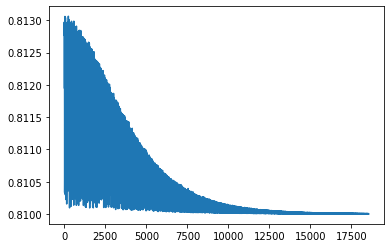

In [16]:
plt.plot([i for i in range(len(losses))], losses)

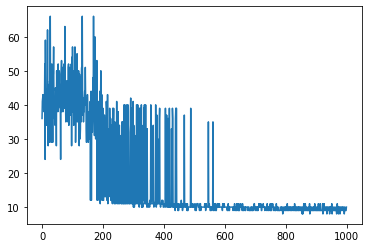

In [17]:
plt.plot([i for i in range(len(rewards))], rewards)

In [13]:
losses, rewards = q_learning(aproximator=aproximator, optimizer=optimizer, env=env, num_epochs=1000, eps=0.9, eps_decay_factor=0.99)

Step 0 @ Episode 1/1000 (1.0)
Step 1 @ Episode 1/1000 (1.0)
Step 2 @ Episode 1/1000 (1.0)
Step 3 @ Episode 1/1000 (1.0)
Step 4 @ Episode 1/1000 (1.0)
Step 5 @ Episode 1/1000 (1.0)
Step 6 @ Episode 1/1000 (1.0)
Step 7 @ Episode 1/1000 (1.0)
Step 8 @ Episode 1/1000 (1.0)
Step 9 @ Episode 1/1000 (1.0)
Step 10 @ Episode 1/1000 (1.0)
Step 11 @ Episode 1/1000 (1.0)
Step 12 @ Episode 1/1000 (1.0)
Step 13 @ Episode 1/1000 (1.0)
Step 14 @ Episode 1/1000 (1.0)
Step 15 @ Episode 1/1000 (1.0)
Step 16 @ Episode 1/1000 (1.0)
Step 17 @ Episode 1/1000 (1.0)
Step 18 @ Episode 1/1000 (1.0)
Step 19 @ Episode 1/1000 (1.0)
Step 20 @ Episode 1/1000 (1.0)
Step 21 @ Episode 1/1000 (1.0)
Step 22 @ Episode 1/1000 (1.0)
Step 23 @ Episode 1/1000 (1.0)


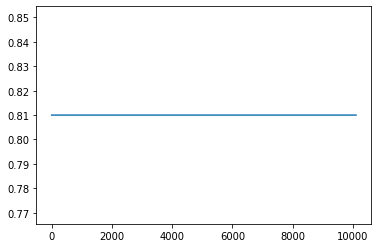

In [14]:
plt.plot([i for i in range(len(losses))], losses)

## Plot the game status

True

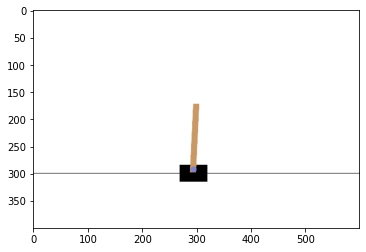

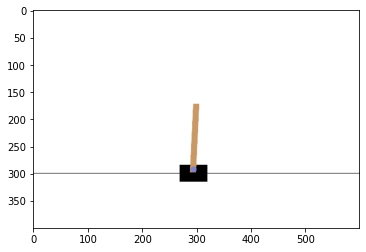

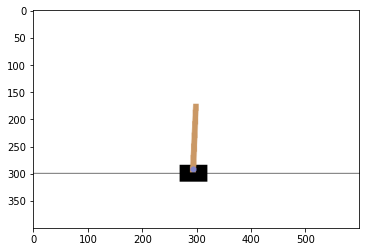

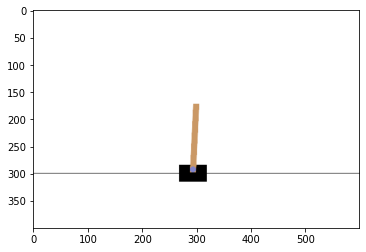

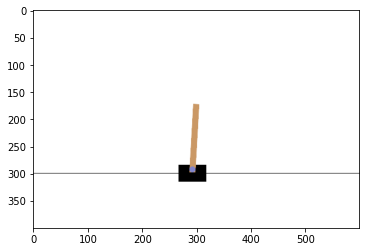

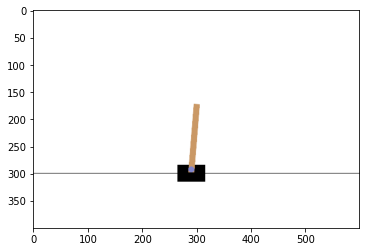

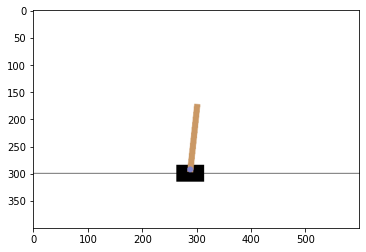

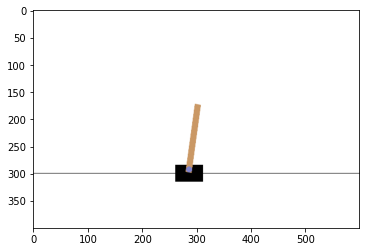

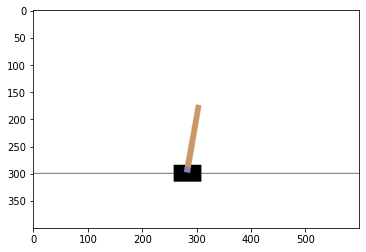

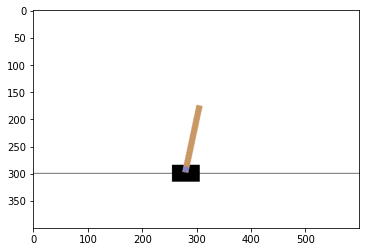

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionReset

In [26]:
state = env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
while(True):
    q_values = aproximator(state).detach().numpy()
    best_action = np.argmax(q_values)
    plt.figure()
    plt.imshow(env.render(mode='rgb_array'))
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
env.render()